In [2]:
!pip install SPARQLWrapper

  Using cached SPARQLWrapper-1.8.5-py3-none-any.whl (26 kB)


You should consider upgrading via the 'c:\users\ottsi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
# %%
#import some modules
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, N3, JSON
from rdflib import Graph
from scipy import stats

In [3]:
polarities = pd.read_csv("polarities.csv", sep=";")
polarities.head(5)

,metric,polarity
0,ACC@1-100Clients,pos
1,AED,neg
2,AKD,neg
3,AP,pos
4,AVERAGE MAE,neg


In [6]:
# %%
#Define here the end point  (i.e. where the blazergraph instance is running)
#current one
endpoint = "http://149.148.229.242:9999/blazegraph/namespace/ito/sparql"
        
prefixes = """
PREFIX edam: <http://edamontology.org/>
PREFIX obo:  <http://purl.obolibrary.org/obo/>
PREFIX ito:  <https://identifiers.org/ito#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
"""


#Use this function to escape some desired_benchmark names that might contain special chars causing crashes.
def escape(s):
    return s.translate(str.maketrans({  "'":   r"\'",
                                        '"':   r'\"',
                                        "\\":  r"\\",
                                        "\r":  r"\r",
                                        "\n":  r"\n"}))


def query(service, query, numeric_cols = []):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()
    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
        
    df = pd.DataFrame(out, columns=cols)
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col])
    
    return df

query = """
    PREFIX edam: <http://edamontology.org/>
    PREFIX obo:  <http://purl.obolibrary.org/obo/>
    PREFIX ito:  <https://identifiers.org/ito:>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>

    SELECT DISTINCT *
    WHERE {
            ?paper a edam:data_0971 . 
            ?paper rdfs:label ?paper_label. 
            ?paper oboInOwl:date ?date. 
            ?model  rdfs:seeAlso ?paper ;
                    rdfs:label ?model_label ;
                    a ?dataset . # this will create a place holder for the rdfs:type results that contains the information about the individual
            ?dataset rdfs:label ?dataset_label ;
                    rdfs:subClassOf* ?top_level_class .
            ?top_level_class rdfs:subClassOf ito:ITO_01625 ;
                            rdfs:label ?top_level_class_label .
            ?metric rdfs:subPropertyOf* ito:performance_measure .
            ?metric rdfs:label ?metric_label .
            ?model ?metric ?result

            FILTER(?top_level_class != ito:Benchmarking) 
            FILTER(?top_level_class != ito:ITO_01524) 
        } ORDER by ?date
"""

#send query via API
sparql = SPARQLWrapper(endpoint)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
result = sparql.query()
#process results as JSON
processed_results = json.load(result.response)

# save to csv
 #Use accessory function to process results
cols = processed_results['head']['vars']
out = []
for row in processed_results['results']['bindings']:
    item = []
    for c in cols:
        item.append(row.get(c, {}).get('value'))
    out.append(item)

#this is the final df containing the results of the query
all = pd.DataFrame(out, columns=cols)


all[['dataset_label', 'task_label']] = all['dataset_label'].str.rsplit(' - ', 1, expand=True)
all["task_label"] = all["task_label"].str.replace(" benchmarking","")


# reorder columns (more hierarchical)
all = all.reindex(columns=['date', 'top_level_class', 'top_level_class_label', 'task_label', 'dataset', 'dataset_label', 'paper', 'paper_label', 'model', 'model_label', 'metric', 'metric_label', 'result'])
all.to_csv("all.csv", index=None)
all.head(5)


,date,top_level_class,top_level_class_label,task_label,dataset,dataset_label,paper,paper_label,model,model_label,metric,metric_label,result
0,2000-09-24,https://identifiers.org/ito:ITO_00126,Biomedical AI process,Atrial Fibrillation Detection,https://identifiers.org/ito:ITO_28989,MIT-BIH AF,https://identifiers.org/ito:ITO_10000,A method for detection of atrial fibrillation ...,https://identifiers.org/ito:ITO_iBBnwwayqk6JXo3DV,/spl Delta/RR intervals model in \'A method fo...,https://identifiers.org/ito:ITO_02411,Accuracy,94.95
1,2003-07-18,https://identifiers.org/ito:ITO_00137,Graph process,Graph Classification,https://identifiers.org/ito:ITO_39851,PROTEINS,https://identifiers.org/ito:ITO_16777,Distinguishing Enzyme Structures from Non-enzy...,https://identifiers.org/ito:ITO_izaNxE1rJseMr89CW,RW model in \'Distinguishing Enzyme Structures...,https://identifiers.org/ito:ITO_02411,Accuracy,74.22
2,2004-07-01,https://identifiers.org/ito:ITO_00141,Natural language processing,Unsupervised Dependency Parsing,https://identifiers.org/ito:ITO_30848,Penn Treebank,https://identifiers.org/ito:ITO_30858,Corpus-Based Induction of Syntactic Structure:...,https://identifiers.org/ito:ITO_iAIZzoiwy3CPQwKP7,DMV model in \'Corpus-Based Induction of Synta...,https://identifiers.org/ito:ITO_11157,UAS,35.9
3,2005-01-01,https://identifiers.org/ito:ITO_00126,Biomedical AI process,Arrhythmia Detection,https://identifiers.org/ito:ITO_31974,MIT-BIH AR,https://identifiers.org/ito:ITO_12116,Support vector machine based arrhythmia classi...,https://identifiers.org/ito:ITO_iUZSTbCtrW509t1JR,SVM model in \'Support vector machine based ar...,https://identifiers.org/ito:ITO_12104,Accuracy (Inter-Patient),76.3
4,2005-01-01,https://identifiers.org/ito:ITO_00126,Biomedical AI process,Arrhythmia Detection,https://identifiers.org/ito:ITO_31974,MIT-BIH AR,https://identifiers.org/ito:ITO_12116,Support vector machine based arrhythmia classi...,https://identifiers.org/ito:ITO_iUZSTbCtrW509t1JR,SVM model in \'Support vector machine based ar...,https://identifiers.org/ito:ITO_12105,Accuracy (Intra-Patient),98.7


In [ ]:
"""
#remove here metrics with problems / ask adriano why removed?
metricName_df = metricName_df[metricName_df!="Accuracy (pose)"]
metricName_df = metricName_df[metricName_df!="F1 (Sequence)"]


traj = traj.drop(traj[traj["metricName"]=="Parameters"].index)
"""

# Experiments below

In [8]:
# generate pairs (for calculating correlation)
from collections import defaultdict
from tqdm import tqdm
doict = defaultdict(list)
grouped = metricName_df.groupby(['benchmark_process_class_label','model_label'])
for _, group in tqdm(grouped):
    res = group[["metricName", "result"]]
    for _, r1 in res.iterrows():
        for _, r2 in res.iterrows():
            if r1["metricName"] != r2["metricName"]:
                doict[(r1["metricName"],r2["metricName"])].append((float(r1["result"]), float(r2["result"])))
# %%
print(len(doict.keys()))

100%|██████████| 23946/23946 [00:19<00:00, 1250.45it/s]

6202


In [18]:
doict_metr = defaultdict(list)

for _, r in metricName_df.iterrows():
    doict_metr[r["metricName"]].append(float(r["result"]))

In [67]:
# calculate correlations
i = 0
rho = []
print(len(doict))

jop = open("jop.txt", "w", encoding="utf8")
nop = open("nop.txt", "w", encoding="utf8")

for key in doict:
    c, v =  zip(*doict[key])
    my_rho = np.corrcoef(np.array(c),np.array(v))

    if len(c) <= 3:
        continue

    if my_rho[1,0] > -0.8 and my_rho[1,0] < 0.8:
        jop.write(str(key))
        jop.write("\t")
        jop.write(str(my_rho[1,0]))
        jop.write("\n")
    else:
        nop.write(str(key))
        nop.write("\t")
        nop.write(str(my_rho[1,0]))
        nop.write("\n")

nop.close()
jop.close()
print(len(rho))

6202


C:\Users\ottsi\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\ottsi\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\ottsi\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\ottsi\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\ottsi\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0


Accuracy
4395
77.0136290784983


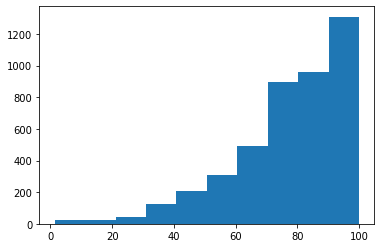

0.001
0.0
The null hypothesis can be rejected
1.8205729802715724e-171
The null hypothesis can be rejected
0
1
0


In [64]:
# distribution test

metr_not_8 = 0
rej = 0
nrej = 0
import statistics
for key in doict_metr:
    key = "Accuracy"
    if len(doict_metr[key]) < 8:
        metr_not_8 += 1
        continue
    print(key)
    print(len(doict_metr[key]))
    print(statistics.mean(doict_metr[key]))

    doict_metr[key] = [x * 100 if x <= 1.0 else x for x in doict_metr[key]]

    histogram = plt.hist(doict_metr[key])
    plt.show()

    alpha = 1e-3
    print(alpha)

    stat, p = stats.kstest(doict_metr[key], stats.uniform(loc=0.0, scale=100.0).cdf)
    print(p)
    if p < alpha:  # null hypothesis: x comes from a uniform distribution 0-100
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")

    k2, p = stats.normaltest(doict_metr[key])
    print(p)
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        rej += 1
        print("The null hypothesis can be rejected")
    else:
        nrej += 1
        print("The null hypothesis cannot be rejected")
    break

print(metr_not_8)
print(rej)
print(nrej)

  0%|          | 0/4321 [00:00<?, ?it/s]

10202    20NEWS - Text Classification benchmarking
10991    20NEWS - Text Classification benchmarking
11007    20NEWS - Text Classification benchmarking
12579    20NEWS - Text Classification benchmarking
15132    20NEWS - Text Classification benchmarking
15139    20NEWS - Text Classification benchmarking
16331    20NEWS - Text Classification benchmarking
19438    20NEWS - Text Classification benchmarking
21244    20NEWS - Text Classification benchmarking
21250    20NEWS - Text Classification benchmarking
21260    20NEWS - Text Classification benchmarking
23330    20NEWS - Text Classification benchmarking
23350    20NEWS - Text Classification benchmarking
23355    20NEWS - Text Classification benchmarking
23375    20NEWS - Text Classification benchmarking
23817    20NEWS - Text Classification benchmarking
25508    20NEWS - Text Classification benchmarking
31831    20NEWS - Text Classification benchmarking
33697    20NEWS - Text Classification benchmarking
37916    20NEWS - Text Classifi

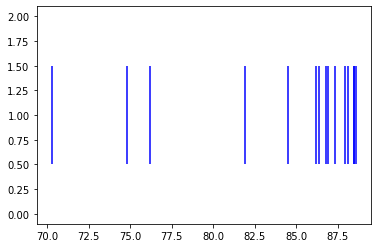

C:\Users\ottsi\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
  0%|          | 0/4321 [00:00<?, ?it/s]

The null hypothesis can be rejected
The null hypothesis cannot be rejected


In [66]:
# distribution test

grouped = metricName_df.groupby(['benchmark_process_class_label'])
for _, group in tqdm(grouped):
    if "Accuracy" in group["metricName"].unique():
        res = group[group["metricName"] == "Accuracy"][["metricName", "result"]]
        if len(res) <=10:
            continue
        print(group["benchmark_process_class_label"])
        print(res)
        
        data = res["result"].astype(float).to_numpy()

        plt.figure()
        plt.eventplot(data, orientation='horizontal', colors='b')
        plt.show()

        stat, p = stats.kstest(data, stats.uniform(loc=0.0, scale=100.0).cdf)
        if p < alpha:  # null hypothesis: x comes from a uniform distribution 0-100
            print("The null hypothesis can be rejected")
        else:
            print("The null hypothesis cannot be rejected")

        k2, p = stats.normaltest(data)
        alpha = 1e-3
        if p < alpha:  # null hypothesis: x comes from a normal distribution
            rej += 1
            print("The null hypothesis can be rejected")
        else:
            nrej += 1
            print("The null hypothesis cannot be rejected")
        break

In [55]:
grouped = metricName_df.groupby(['benchmark_process_class_label','model_label'])
for _, group in tqdm(grouped):
    print(group)
    for metric in group["metricName"].unique():
        pass
    break

  0%|          | 0/23946 [00:00<?, ?it/s]

                                       paper  \
14453  https://identifiers.org/ito:ITO_12100   
14454  https://identifiers.org/ito:ITO_12100   

                                              paperTitle        date  \
14453  Cardiologist-level arrhythmia detection and cl...  2019-01-07   
14454  Cardiologist-level arrhythmia detection and cl...  2019-01-07   

                            benchmark_process_individual  \
14453  https://identifiers.org/ito:ITO_igFM4bn92F0EAjX6K   
14454  https://identifiers.org/ito:ITO_igFM4bn92F0EAjX6K   

                                             model_label  \
14453  Cardiologists Averaged model in \'Cardiologist...   
14454  Cardiologists Averaged model in \'Cardiologist...   

                     benchmark_process_class  \
14453  https://identifiers.org/ito:ITO_31987   
14454  https://identifiers.org/ito:ITO_31987   

                           benchmark_process_class_label  \
14453  "Cardiologist-level" 12-rhythm ECG dataset - A...   
14454  "Car

20NEWS - Text Classification benchmarking
Accuracy
    index                                  paper  \
0   10202  https://identifiers.org/ito:ITO_14685   
1   11007  https://identifiers.org/ito:ITO_14727   
2   12579  https://identifiers.org/ito:ITO_11727   
3   15132  https://identifiers.org/ito:ITO_04763   
4   15139  https://identifiers.org/ito:ITO_04763   
5   16331  https://identifiers.org/ito:ITO_14732   
6   19438  https://identifiers.org/ito:ITO_02729   
7   21250  https://identifiers.org/ito:ITO_14725   
8   21260  https://identifiers.org/ito:ITO_14725   
9   23375  https://identifiers.org/ito:ITO_14738   
10  23817  https://identifiers.org/ito:ITO_36585   
11  25508  https://identifiers.org/ito:ITO_36582   
12  31831  https://identifiers.org/ito:ITO_36622   
13  33697  https://identifiers.org/ito:ITO_36547   
14  37923  https://identifiers.org/ito:ITO_36619   

                                           paperTitle        date  \
0   RMDL: Random Multimodel Deep Learning for C

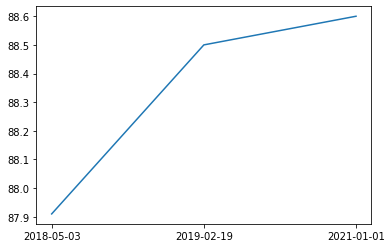

300W - Face Alignment benchmarking
Fullset (public)
    index                                  paper  \
0    6115  https://identifiers.org/ito:ITO_03434   
1    9432  https://identifiers.org/ito:ITO_03444   
2    9749  https://identifiers.org/ito:ITO_03445   
3   10559  https://identifiers.org/ito:ITO_03436   
4   12265  https://identifiers.org/ito:ITO_03398   
5   14950  https://identifiers.org/ito:ITO_03427   
6   14951  https://identifiers.org/ito:ITO_03427   
7   15933  https://identifiers.org/ito:ITO_03438   
8   16404  https://identifiers.org/ito:ITO_03432   
9   16893  https://identifiers.org/ito:ITO_18993   
10  16898  https://identifiers.org/ito:ITO_18993   
11  19067  https://identifiers.org/ito:ITO_03425   
12  19068  https://identifiers.org/ito:ITO_03425   
13  22415  https://identifiers.org/ito:ITO_03430   
14  22416  https://identifiers.org/ito:ITO_03430   
15  29549  https://identifiers.org/ito:ITO_19004   
16  31845  https://identifiers.org/ito:ITO_18999   

           

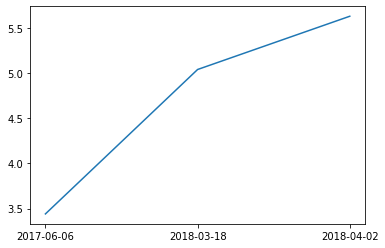

3DMatch Benchmark - Point Cloud Registration benchmarking
Recall
    index                                  paper  \
0      33  https://identifiers.org/ito:ITO_32492   
1    2972  https://identifiers.org/ito:ITO_06287   
2    8970  https://identifiers.org/ito:ITO_32490   
3   12145  https://identifiers.org/ito:ITO_32487   
4   13507  https://identifiers.org/ito:ITO_32484   
5   22788  https://identifiers.org/ito:ITO_15908   
6   25410  https://identifiers.org/ito:ITO_32481   
7   25411  https://identifiers.org/ito:ITO_32481   
8   25544  https://identifiers.org/ito:ITO_32479   
9   30873  https://identifiers.org/ito:ITO_32471   
10  32582  https://identifiers.org/ito:ITO_32477   
11  35824  https://identifiers.org/ito:ITO_32474   
12  37875  https://identifiers.org/ito:ITO_32469   

                                           paperTitle        date  \
0   Fast Point Feature Histograms (FPFH) for 3D Re...  2009-05-12   
1   3DMatch: Learning Local Geometric Descriptors ...  2016-03-27   

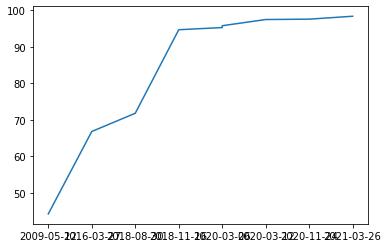

3DPW - 3D Human Pose Estimation benchmarking
MPJPE
    index                                  paper  \
0    8534  https://identifiers.org/ito:ITO_04940   
1   21985  https://identifiers.org/ito:ITO_04934   
2   24090  https://identifiers.org/ito:ITO_04932   
3   30406  https://identifiers.org/ito:ITO_21999   
4   30407  https://identifiers.org/ito:ITO_22021   
5   30601  https://identifiers.org/ito:ITO_22019   
6   30807  https://identifiers.org/ito:ITO_22009   
7   32430  https://identifiers.org/ito:ITO_22016   
8   32795  https://identifiers.org/ito:ITO_21985   
9   33349  https://identifiers.org/ito:ITO_22011   
10  35946  https://identifiers.org/ito:ITO_22014   
11  35947  https://identifiers.org/ito:ITO_22023   
12  36720  https://identifiers.org/ito:ITO_22007   

                                           paperTitle        date  \
0         End-to-end Recovery of Human Shape and Pose  2017-12-18   
1   Learning to Reconstruct 3D Human Pose and Shap...  2019-09-27   
2   VIBE: Vid

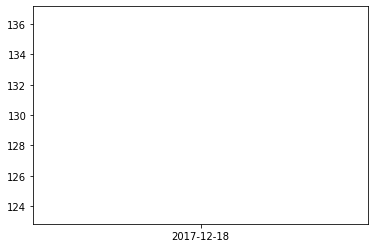

3DPW - 3D Human Pose Estimation benchmarking
PA-MPJPE
    index                                  paper  \
0    8540  https://identifiers.org/ito:ITO_04940   
1   17694  https://identifiers.org/ito:ITO_05024   
2   20922  https://identifiers.org/ito:ITO_04936   
3   21988  https://identifiers.org/ito:ITO_04934   
4   24105  https://identifiers.org/ito:ITO_04932   
5   26473  https://identifiers.org/ito:ITO_04893   
6   26474  https://identifiers.org/ito:ITO_22029   
7   30429  https://identifiers.org/ito:ITO_22021   
8   30431  https://identifiers.org/ito:ITO_21999   
9   30627  https://identifiers.org/ito:ITO_22019   
10  30628  https://identifiers.org/ito:ITO_18785   
11  30814  https://identifiers.org/ito:ITO_22009   
12  31175  https://identifiers.org/ito:ITO_22026   
13  32440  https://identifiers.org/ito:ITO_22016   
14  32853  https://identifiers.org/ito:ITO_21985   
15  33369  https://identifiers.org/ito:ITO_22011   
16  35999  https://identifiers.org/ito:ITO_22014   
17  36000 

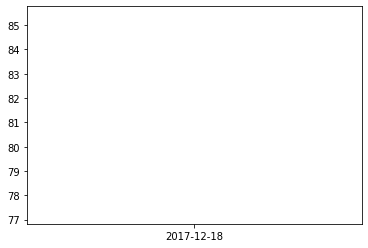

A2D Sentences - Referring Expression Segmentation benchmarking
AP
    index                                  paper  \
0    2917  https://identifiers.org/ito:ITO_39194   
1    6397  https://identifiers.org/ito:ITO_39192   
2    9473  https://identifiers.org/ito:ITO_39190   
3    9475  https://identifiers.org/ito:ITO_39190   
4   22132  https://identifiers.org/ito:ITO_39188   
5   26251  https://identifiers.org/ito:ITO_39184   
6   28278  https://identifiers.org/ito:ITO_39186   
7   29978  https://identifiers.org/ito:ITO_39181   
8   32222  https://identifiers.org/ito:ITO_39179   
9   35420  https://identifiers.org/ito:ITO_39173   
10  37726  https://identifiers.org/ito:ITO_39177   
11  37754  https://identifiers.org/ito:ITO_39175   
12  37755  https://identifiers.org/ito:ITO_39175   

                                           paperTitle        date  \
0      Segmentation from Natural Language Expressions  2016-03-20   
1          Tracking by Natural Language Specification  2017-07-01  

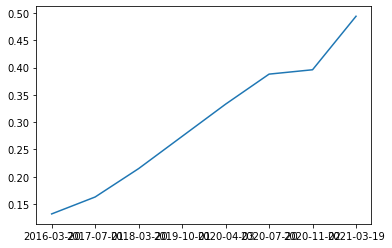

A2D Sentences - Referring Expression Segmentation benchmarking
IoU mean
    index                                  paper  \
0    2920  https://identifiers.org/ito:ITO_39194   
1    6422  https://identifiers.org/ito:ITO_39192   
2    9480  https://identifiers.org/ito:ITO_39190   
3    9482  https://identifiers.org/ito:ITO_39190   
4   22205  https://identifiers.org/ito:ITO_39188   
5   26272  https://identifiers.org/ito:ITO_39184   
6   28349  https://identifiers.org/ito:ITO_39186   
7   30014  https://identifiers.org/ito:ITO_39181   
8   31398  https://identifiers.org/ito:ITO_39142   
9   32227  https://identifiers.org/ito:ITO_39179   
10  34341  https://identifiers.org/ito:ITO_39196   
11  35442  https://identifiers.org/ito:ITO_39173   
12  37731  https://identifiers.org/ito:ITO_39177   
13  37759  https://identifiers.org/ito:ITO_39175   
14  37765  https://identifiers.org/ito:ITO_39175   

                                           paperTitle        date  \
0      Segmentation from N

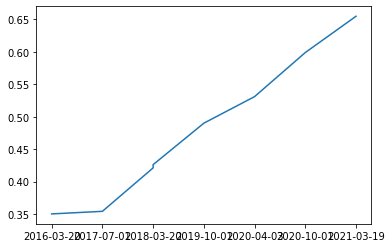

A2D Sentences - Referring Expression Segmentation benchmarking
IoU overall
    index                                  paper  \
0    2919  https://identifiers.org/ito:ITO_39194   
1    6421  https://identifiers.org/ito:ITO_39192   
2    9479  https://identifiers.org/ito:ITO_39190   
3    9481  https://identifiers.org/ito:ITO_39190   
4   22204  https://identifiers.org/ito:ITO_39188   
5   26271  https://identifiers.org/ito:ITO_39184   
6   28348  https://identifiers.org/ito:ITO_39186   
7   30013  https://identifiers.org/ito:ITO_39181   
8   31397  https://identifiers.org/ito:ITO_39142   
9   32226  https://identifiers.org/ito:ITO_39179   
10  34345  https://identifiers.org/ito:ITO_39196   
11  35441  https://identifiers.org/ito:ITO_39173   
12  37730  https://identifiers.org/ito:ITO_39177   
13  37758  https://identifiers.org/ito:ITO_39175   
14  37764  https://identifiers.org/ito:ITO_39175   

                                           paperTitle        date  \
0      Segmentation fro

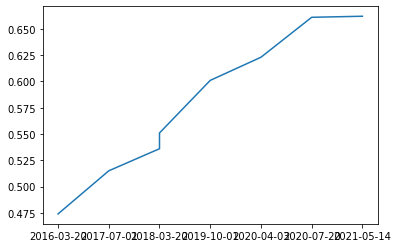

A2D Sentences - Referring Expression Segmentation benchmarking
Precision@0.5
    index                                  paper  \
0    2913  https://identifiers.org/ito:ITO_39194   
1    6351  https://identifiers.org/ito:ITO_39192   
2    9459  https://identifiers.org/ito:ITO_39190   
3    9464  https://identifiers.org/ito:ITO_39190   
4   22116  https://identifiers.org/ito:ITO_39188   
5   26240  https://identifiers.org/ito:ITO_39184   
6   28256  https://identifiers.org/ito:ITO_39186   
7   29951  https://identifiers.org/ito:ITO_39181   
8   31364  https://identifiers.org/ito:ITO_39142   
9   32216  https://identifiers.org/ito:ITO_39179   
10  34317  https://identifiers.org/ito:ITO_39196   
11  35413  https://identifiers.org/ito:ITO_39173   
12  37717  https://identifiers.org/ito:ITO_39177   
13  37734  https://identifiers.org/ito:ITO_39175   
14  37738  https://identifiers.org/ito:ITO_39175   

                                           paperTitle        date  \
0      Segmentation f

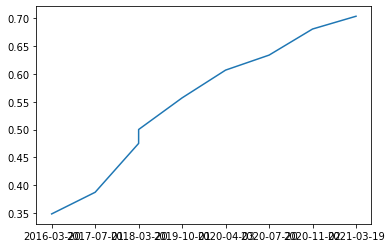

A2D Sentences - Referring Expression Segmentation benchmarking
Precision@0.6
    index                                  paper  \
0    2914  https://identifiers.org/ito:ITO_39194   
1    6352  https://identifiers.org/ito:ITO_39192   
2    9460  https://identifiers.org/ito:ITO_39190   
3    9465  https://identifiers.org/ito:ITO_39190   
4   22117  https://identifiers.org/ito:ITO_39188   
5   26241  https://identifiers.org/ito:ITO_39184   
6   28257  https://identifiers.org/ito:ITO_39186   
7   29952  https://identifiers.org/ito:ITO_39181   
8   32217  https://identifiers.org/ito:ITO_39179   
9   34318  https://identifiers.org/ito:ITO_39196   
10  35414  https://identifiers.org/ito:ITO_39173   
11  37718  https://identifiers.org/ito:ITO_39177   
12  37735  https://identifiers.org/ito:ITO_39175   
13  37739  https://identifiers.org/ito:ITO_39175   

                                           paperTitle        date  \
0      Segmentation from Natural Language Expressions  2016-03-20   
1   

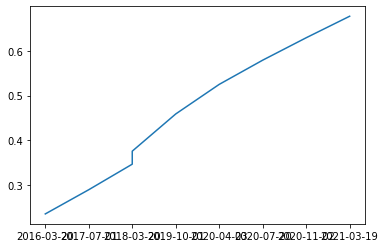

  1%|▏         | 112/7536 [00:01<01:25, 87.11it/s]


In [125]:
# plot sota curves

i = 0
grouped = metricName_df.groupby(['benchmark_process_class_label', 'metricName'])
for _, group in tqdm(grouped):
    if len(group) <=10:
        continue
    i += 1
    print(group["benchmark_process_class_label"].iloc[0])
    print(group["metricName"].iloc[0])

    group = group.copy(deep=True).reset_index()

    print(group)

    group["result"] = group["result"].astype(float)
    

    filter = pd.Series([False for _ in range(len(group))])

    print(filter)

    max = float('-inf')
    for index, row in group.iterrows():
        if row["result"] >= max:
            filter[index] = True
            max = row["result"]


    group = group[filter]
    data = group["result"].astype(float).to_numpy()

    print(group.columns)
    plt.figure()
    plt.plot(group["date"], group["result"].astype(float))
    #plt.eventplot(data, orientation='horizontal', colors='b')
    
    plt.show()

    if i == 10:
        break

In [92]:
s = pd.Series([90, 95, 60, 65])

0         NaN
1    0.055556
2   -0.368421
3    0.083333
dtype: float64

20NEWS - Text Classification benchmarking
Accuracy
300W - Face Alignment benchmarking
Fullset (public)
3DMatch Benchmark - Point Cloud Registration benchmarking
Recall
[0.51131222 0.0748503  0.3189415  0.0063358  0.00524659 0.0177453
 0.00102564 0.00819672]
 
-0.05709 x + 0.3178


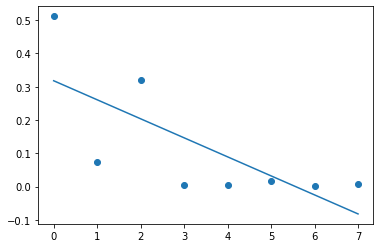

3DPW - 3D Human Pose Estimation benchmarking
MPJPE
3DPW - 3D Human Pose Estimation benchmarking
PA-MPJPE
A2D Sentences - Referring Expression Segmentation benchmarking
AP
[0.23484848 0.3190184  0.2744186  0.21532847 0.16516517 0.02061856
 0.24747475]
 
-0.02386 x + 0.2826


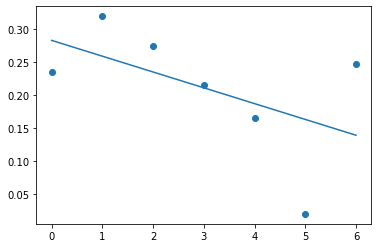

A2D Sentences - Referring Expression Segmentation benchmarking
IoU mean
[0.01142857 0.18926554 0.01187648 0.15023474 0.08367347 0.12806026
 0.09348915]
 
0.006985 x + 0.07448


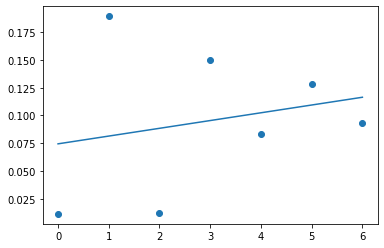

A2D Sentences - Referring Expression Segmentation benchmarking
IoU overall
[0.08649789 0.0407767  0.02798507 0.0907441  0.03660566 0.06099518
 0.00151286]
 
-0.007353 x + 0.07136


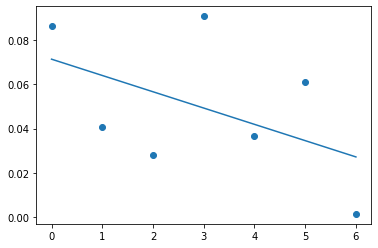

A2D Sentences - Referring Expression Segmentation benchmarking
Precision@0.5
[0.11206897 0.22739018 0.05263158 0.114      0.08976661 0.04448105
 0.07413249 0.03377386]
 
-0.01623 x + 0.1503


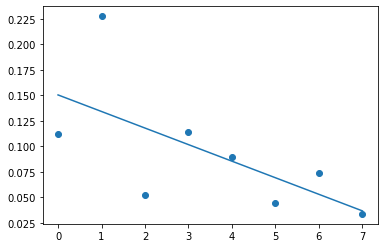

A2D Sentences - Referring Expression Segmentation benchmarking
Precision@0.6
[0.22881356 0.19655172 0.08357349 0.22074468 0.14379085 0.10285714
 0.08635579 0.07631161]
 
-0.0195 x + 0.2106


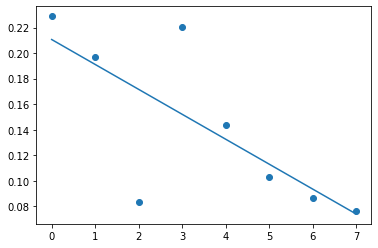

  1%|▏         | 109/7536 [00:00<00:54, 137.15it/s]

10


In [148]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures



i = 0
grouped = metricName_df.groupby(['benchmark_process_class_label', 'metricName'])
for _, group in tqdm(grouped):
    if len(group) <=10:
        continue
    i += 1
    print(group["benchmark_process_class_label"].iloc[0])
    print(group["metricName"].iloc[0])
    group = group.copy(deep=True).reset_index()
    group["result"] = group["result"].astype(float)

    
    filter = pd.Series([False for _ in range(len(group))])
    max = float('-inf')
    for index, row in group.iterrows():
        if row["result"] >= max:
            filter[index] = True
            max = row["result"]
    group = group[filter]

    if len(group) <= 4:
        continue
    
    model = LinearRegression()
    transformer = PolynomialFeatures(degree=2, include_bias=False)

    
    y = group["result"].astype(float).pct_change().to_numpy()[1:]
    x = np.array(list(range(len(y))))
    print(y)
    mymodel = np.poly1d(np.polyfit(x, y, 1))

    print(mymodel)

    plt.scatter(x, y)
    plt.plot(x, mymodel(x))
    #plt.ylim(0.0,1.0)
    plt.show()

    if i == 10:
        break
print(i)

1    2.000000
2    0.666667
dtype: float64


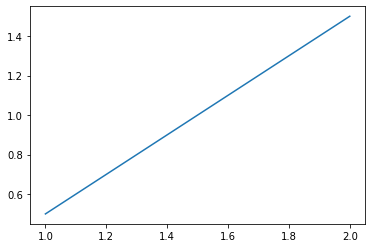

In [162]:
a = pd.Series([0.1,0.3,0.5])
a = a.pct_change()[1:]
print(a)
plt.plot(1/a)